In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import orjsonl
import numpy as np

In [102]:
all_values = []
datas = []
names = ["short", "truncated long", "TIPO + short", "TIPO + truncated long"]
model_order = [
    "short",
    "TIPO + short",
    "truncated long",
    "TIPO + truncated long",
]
for name, data in zip(names, orjsonl.load("./coyo-ai-corrupt.jsonl", "rb")):
    datas.extend((name, d) for d in data)
    all_values.extend(data)
for name, data in zip(names, orjsonl.load("./gbc-ai-corrupt.jsonl", "rb")):
    datas.extend((name, d) for d in data)
    all_values.extend(data)
all_values = np.array(all_values)
df = pd.DataFrame(datas, columns=["model", "ai_corrupt"])
print(df)
print(df["ai_corrupt"].min(), df["ai_corrupt"].max())

                       model  ai_corrupt
0                      short    0.693599
1                      short    0.295584
2                      short    0.705920
3                      short    0.802875
4                      short    0.007526
...                      ...         ...
79995  TIPO + truncated long    0.162923
79996  TIPO + truncated long    0.204599
79997  TIPO + truncated long    0.859470
79998  TIPO + truncated long    0.559704
79999  TIPO + truncated long    0.603184

[80000 rows x 2 columns]
0.00010383129119873047 0.999702689354308


In [103]:
min = df["ai_corrupt"].min()
max = df["ai_corrupt"].max()
std = df["ai_corrupt"].std()
mean = df["ai_corrupt"].mean()

# df["ai_corrupt"] = (df["ai_corrupt"] - mean) / std
print(min, max, std, mean)

0.00010383129119873047 0.999702689354308 0.33843261400867625 0.548080367099696


In [104]:
y_scale = 1.0
box_scale = 0.7

C:\Users\apoll\AppData\Local\Temp\ipykernel_16532\3437339824.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df_sorted.groupby("model")["ai_corrupt"].quantile(
C:\Users\apoll\AppData\Local\Temp\ipykernel_16532\3437339824.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_sorted.groupby("model")["ai_corrupt"].mean()
C:\Users\apoll\AppData\Local\Temp\ipykernel_16532\3437339824.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future

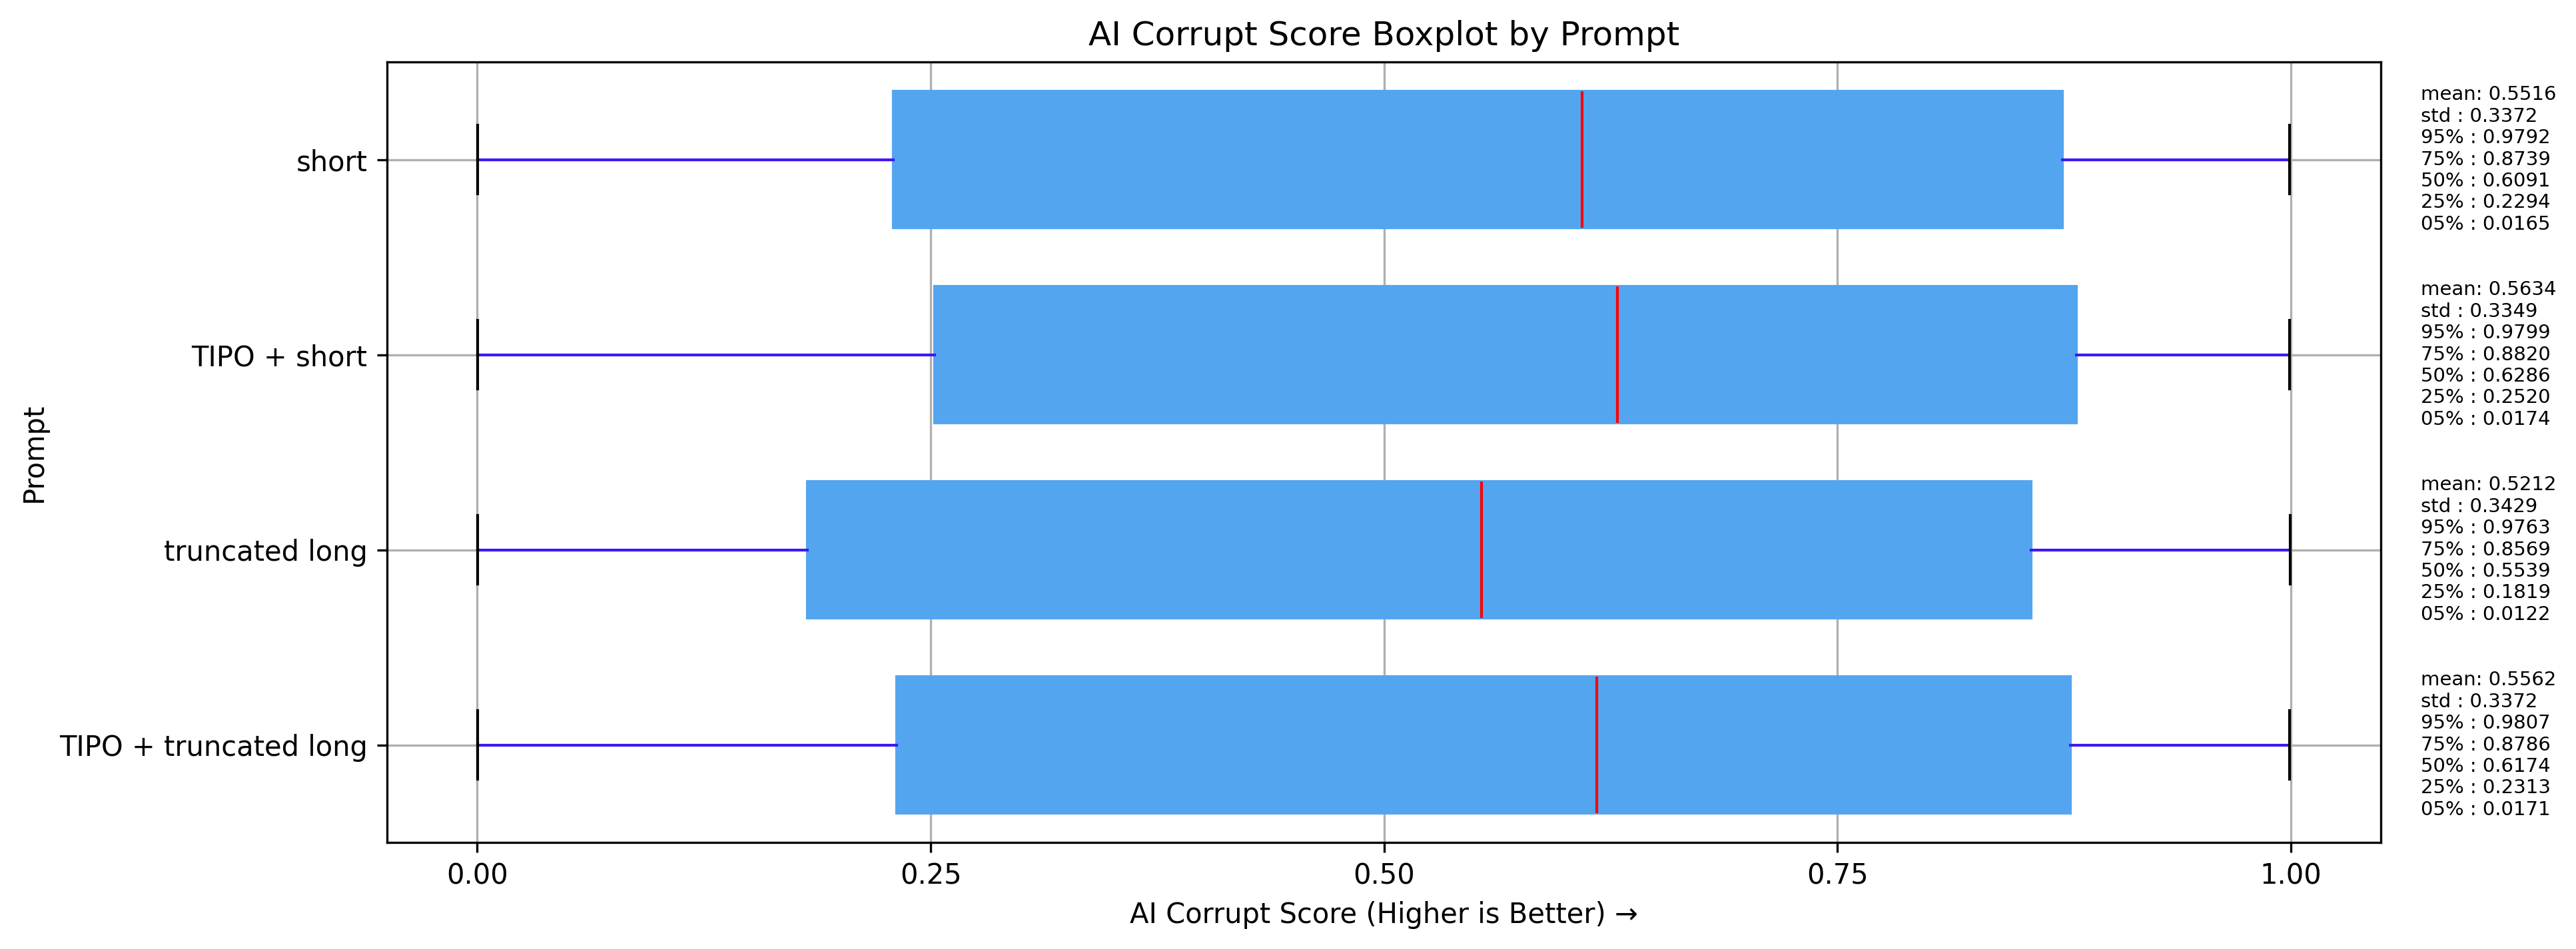


Quantiles for each model:
model                      
TIPO + truncated long  0.05    0.017085
                       0.25    0.231321
                       0.50    0.617368
                       0.75    0.878598
                       0.95    0.980683
truncated long         0.05    0.012247
                       0.25    0.181891
                       0.50    0.553895
                       0.75    0.856910
                       0.95    0.976258
TIPO + short           0.05    0.017356
                       0.25    0.252004
                       0.50    0.628602
                       0.75    0.881953
                       0.95    0.979901
short                  0.05    0.016525
                       0.25    0.229442
                       0.50    0.609118
                       0.75    0.873913
                       0.95    0.979215
Name: ai_corrupt, dtype: float64


In [105]:
# Calculate statistics for sorting
df_stats = (
    df.groupby("model").agg({"ai_corrupt": ["mean", lambda x: x.mean()]}).reset_index()
)
df_stats.columns = ["model", "mean", "ai_corrupt"]

# Choose sorting method (uncomment the desired method)
# df_stats_sorted = df_stats.sort_values('median', ascending=False)
df_stats_sorted = df_stats.sort_values("mean", ascending=False)

# Sort the original dataframe based on the stats
df_sorted = df.set_index("model").loc[model_order].reset_index()
# print(df_stats)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(13, 5), dpi=300)

df_sorted["model"] = pd.Categorical(
    df_sorted["model"],
    categories=reversed(list(df_sorted["model"].unique())),
    ordered=True,
)
positions = [i * y_scale for i in range(len(model_order))]
# Create the horizontal boxplot using the sorted data
boxplot = df_sorted.boxplot(
    column="ai_corrupt",
    by="model",
    vert=False,
    ax=ax,
    patch_artist=True,
    medianprops={"color": "red"},
    showfliers=False,
    color={
        "boxes": "#54A5F0",
        "whiskers": "#4016F5",
        "medians": "red",
        "caps": "black",
    },
    positions=positions,
    widths=[box_scale] * len(model_order),
)

# Customize the plot
ax.set_title("AI Corrupt Score Boxplot by Prompt")
ax.set_ylabel("Prompt")
ax.set_xlabel("AI Corrupt Score (Higher is Better) →")

# Remove the automatically generated suptitle
plt.suptitle("")

# Adjust the y-axis tick labels
plt.yticks(rotation=0)

# Adjust the data range and tick marks
min_score = df["ai_corrupt"].min()
max_score = df["ai_corrupt"].max()
range_margin = (max_score - min_score) * 0.05
# ax.set_xlim(-1.5, 1.5)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.25))

# Calculate and add quantile information
quantiles = df_sorted.groupby("model")["ai_corrupt"].quantile(
    [0.05, 0.25, 0.5, 0.75, 0.95]
)
reverse_map = {
    v1: v2
    for v1, v2 in zip(
        df_sorted["model"].unique(), reversed(df_sorted["model"].unique())
    )
}

means = df_sorted.groupby("model")["ai_corrupt"].mean()
std = df_sorted.groupby("model")["ai_corrupt"].std()

# print(quantiles)
for i, model in enumerate(df_sorted["model"].unique()):
    model = reverse_map[model]
    quantile_text = (
        f"mean: {means.loc[model]:.4f}\n"
        f"std : {std.loc[model]:.4f}\n"
        f"95% : {quantiles.loc[model, 0.95]:.4f}\n"
        f"75% : {quantiles.loc[model, 0.75]:.4f}\n"
        f"50% : {quantiles.loc[model, 0.50]:.4f}\n"
        f"25% : {quantiles.loc[model, 0.25]:.4f}\n"
        f"05% : {quantiles.loc[model, 0.05]:.4f}"
    )
    ax.annotate(
        quantile_text,
        xy=(1.02, i * y_scale),
        xycoords=("axes fraction", "data"),
        va="center",
        ha="left",
        fontsize=7,
    )

# Display the plot
plt.tight_layout()
plt.show()

# Log quantile information
print("\nQuantiles for each model:")
print(quantiles)